## Loading data and necessary libraries

In [86]:
%pip install pandas
%pip install xgboost

Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'C:\Users\DimitraGiannouli\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip' command.


Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'C:\Users\DimitraGiannouli\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip' command.


In [87]:
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
import xgboost as xgb
from sklearn.metrics import accuracy_score,classification_report, confusion_matrix, roc_curve, auc

In [88]:
# Load dataset
df_churn = pd.read_csv('Bank Customer Churn Prediction.csv')

## EDA (Analysing Data)

In [89]:
df_churn.head()

,customer_id,credit_score,country,gender,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn
0,15634602,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,15647311,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,15619304,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,15701354,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,15737888,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [90]:
df_churn.shape # 10,000 records (rows ) , 12 features (columns)

(10000, 12)

In [91]:
df_churn[['credit_score','age','balance','estimated_salary']].describe()

#we can see that we have outliers in balance as mean (which is sensitive to outliers) is ~76,485 and min is 0.

,credit_score,age,balance,estimated_salary
count,10000.000000,10000.000000,10000.000000,10000.000000
mean,650.528800,38.921800,76485.889288,100090.239881
std,96.653299,10.487806,62397.405202,57510.492818
min,350.000000,18.000000,0.000000,11.580000
25%,584.000000,32.000000,0.000000,51002.110000
50%,652.000000,37.000000,97198.540000,100193.915000
75%,718.000000,44.000000,127644.240000,149388.247500
max,850.000000,92.000000,250898.090000,199992.480000


In [92]:
df_churn.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customer_id       10000 non-null  int64  
 1   credit_score      10000 non-null  int64  
 2   country           10000 non-null  object 
 3   gender            10000 non-null  object 
 4   age               10000 non-null  int64  
 5   tenure            10000 non-null  int64  
 6   balance           10000 non-null  float64
 7   products_number   10000 non-null  int64  
 8   credit_card       10000 non-null  int64  
 9   active_member     10000 non-null  int64  
 10  estimated_salary  10000 non-null  float64
 11  churn             10000 non-null  int64  
dtypes: float64(2), int64(8), object(2)
memory usage: 937.6+ KB


In [93]:
#Male customers are the majority (M - 55%, F- 45%)
gender_count = df_churn['gender'].value_counts(normalize=True)* 100
gender_count

Male      54.57
Female    45.43
Name: gender, dtype: float64

In [94]:
# While the number of male customers was generally bigger than the female customers, women who left were more than men (25% women who left vs 16% men)
gender_churn_count = df_churn.groupby('gender')['churn'].value_counts(normalize=True)* 100
gender_churn_count

gender  churn
Female  0        74.928461
        1        25.071539
Male    0        83.544072
        1        16.455928
Name: churn, dtype: float64

In [95]:
active_member_count = df_churn.groupby('active_member')['churn'].value_counts(normalize=True)*100 # non-active members tend to churn more than active members
active_member_count

active_member  churn
0              0        73.149103
               1        26.850897
1              0        85.730926
               1        14.269074
Name: churn, dtype: float64

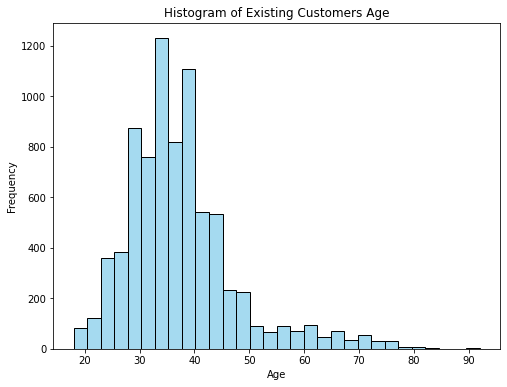

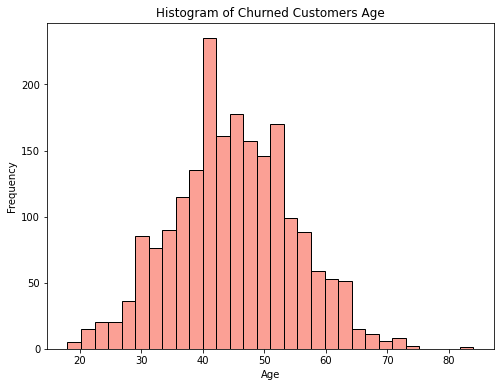

In [96]:
# Histogram for 'age' variable for existing and churned customers
plt.figure(figsize=(8, 6))
sns.histplot(df_churn[df_churn['churn']== 0]['age'], bins=30, kde=False, color='skyblue')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.title('Histogram of Existing Customers Age')
plt.show()

plt.figure(figsize=(8, 6))
sns.histplot(df_churn[df_churn['churn']== 1]['age'], bins=30, kde=False, color='salmon')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.title('Histogram of Churned Customers Age')
plt.show()




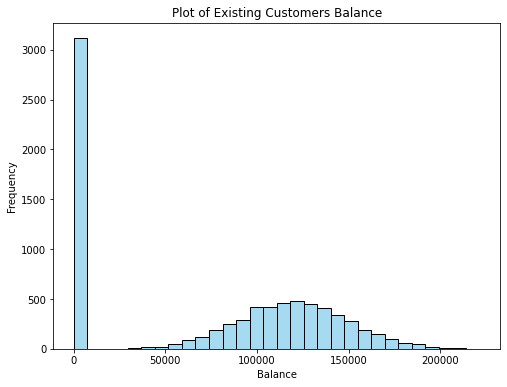

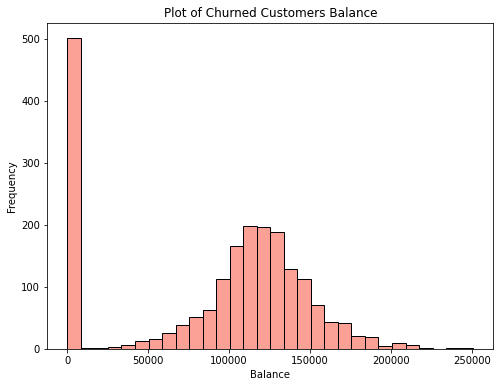

In [97]:
# Histogram plots for 'balance' variable
plt.figure(figsize=(8, 6))
sns.histplot(df_churn[df_churn['churn']== 0]['balance'], bins=30, kde=False, color='skyblue')
plt.xlabel('Balance')
plt.ylabel('Frequency')
plt.title('Plot of Existing Customers Balance')
plt.show()

plt.figure(figsize=(8, 6))
sns.histplot(df_churn[df_churn['churn']== 1]['balance'], bins=30, kde=False, color='salmon')
plt.xlabel('Balance')
plt.ylabel('Frequency')
plt.title('Plot of Churned Customers Balance')
plt.show()

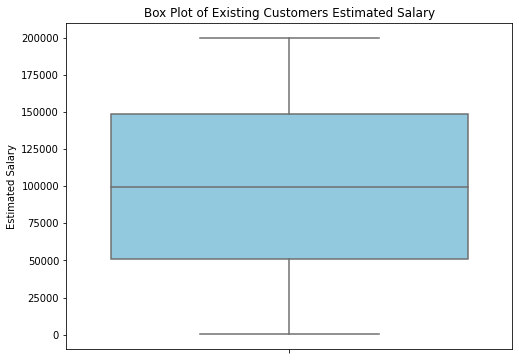

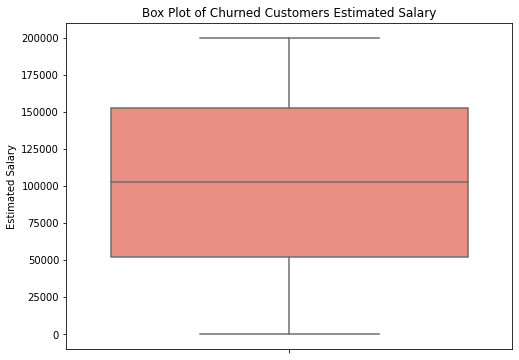

In [98]:
# Box plots for 'estimated_salary' variable
plt.figure(figsize=(8, 6))
sns.boxplot(y='estimated_salary', data=df_churn[df_churn['churn']== 0], color='skyblue')
plt.ylabel('Estimated Salary')
plt.title('Box Plot of Existing Customers Estimated Salary')
plt.show()

plt.figure(figsize=(8, 6))
sns.boxplot(y='estimated_salary', data=df_churn[df_churn['churn']== 1], color='salmon')
plt.ylabel('Estimated Salary')
plt.title('Box Plot of Churned Customers Estimated Salary')
plt.show()

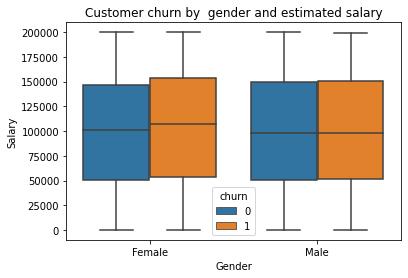

In [99]:
sns.boxplot(data=df_churn, x='gender', y='estimated_salary',hue='churn') # we realise that women who churn have slightly higher salary than men and women who haven't churned (a bit above 100,000)

plt.title('Customer churn by  gender and estimated salary')
plt.xlabel('Gender')
plt.ylabel('Salary')

# Show plot
plt.show()

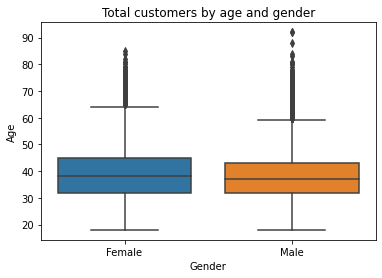

In [100]:
#Understanding demographic differences - The male median age is slightly less than the female approx 35 years for males, 37 for females

sns.boxplot(data=df_churn, x='gender', y='age')

plt.title('Total customers by age and gender')
plt.xlabel('Gender')
plt.ylabel('Age')

# Show plot
plt.show()

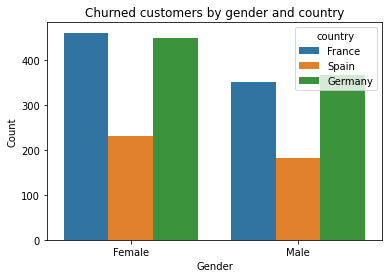

In [101]:
#Understanding demographic differences to the customers that churned - females tend to churn more than males, also Spanish customers tend to stay, and the majority of churned customers 
#are French closely followed from German. 

sns.countplot(data= df_churn[df_churn['churn'] == 1], x = 'gender', hue='country')

plt.title('Churned customers by gender and country')
plt.xlabel('Gender')
plt.ylabel('Count')

# Show plot
plt.show()

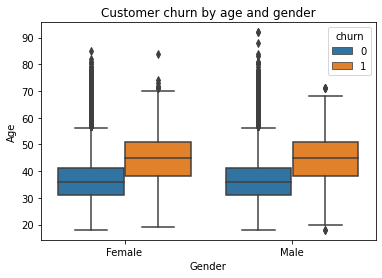

In [102]:
#Plot if there are age differences to customers that churn. Seems that they tend to churn in an older age between 40-50 with a median of ~45. 

sns.boxplot(data=df_churn, x='gender', y='age',hue='churn')

plt.title('Customer churn by age and gender')
plt.xlabel('Gender')
plt.ylabel('Age')

# Show plot
plt.show()

Observations:</br> 1. Most females than males churn</br> 2. Women who churn tend to have higher salaries</br> 3. Customers tend to churn in older ages with a median of 45</br> 4. French people tend to churn more followed by German.</br> 5. People with higher balances leave bank more frequently

# Data Preprocessing/Featurisation

In [103]:
# Split data into features and labels, drop unecessary columns (eg high-cardinality columns)
X = df_churn.drop(['churn','customer_id'], axis=1)
y = df_churn['churn']

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)



### Deal with missing values

In [104]:
missing_values = df_churn.isnull()
missing_counts = missing_values.sum()
total_missing_counts = missing_counts.sum()
total_missing_counts

0

Note: We would have applied an Imputer object for handling missing values, but there are no missing values in our case.

### Feature Scaling (numerical features) and Encoding (categorical features)

In [105]:
# Identify numeric and categorical features
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

# Define transformers for numeric and categorical features
categorical_features = X.select_dtypes(include=['object']).columns
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Create a ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Define the pipeline
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', xgb.XGBClassifier())
])

 ### Model training - Ensemble learning (Extreme Gradient Boosting) and Hyperparameter Tuning

In [106]:

# Define hyperparameters grid
param_grid = {
    'classifier__n_estimators': [100, 200, 300],
    'classifier__max_depth': [3, 5, 7],
    'classifier__learning_rate': [0.01, 0.1, 0.3]
}

# Perform Grid Search Cross Validation
grid_search = GridSearchCV(pipeline, param_grid, cv=5, n_jobs=-1)
grid_search.fit(X_train, y_train)

# Get best parameters and score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

# Get model with best parameters
best_model_xgb = grid_search.best_estimator_

# Predictions on test set
y_pred = best_model_xgb.predict(X_test)
y_proba = best_model_xgb.predict_proba(X_test)[:, 1]


### Evaluate Model

In [107]:
# Print metrics

print('Accuracy:\n',accuracy_score(y_test, y_pred))
print('\nClassification Report:\n',classification_report(y_test,y_pred))
print('\nConfusion Matrix:\n',confusion_matrix(y_test,y_pred))

Accuracy:
 0.867

Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.96      0.92      1607
           1       0.74      0.50      0.59       393

    accuracy                           0.87      2000
   macro avg       0.81      0.73      0.76      2000
weighted avg       0.86      0.87      0.86      2000


Confusion Matrix:
 [[1539   68]
 [ 198  195]]


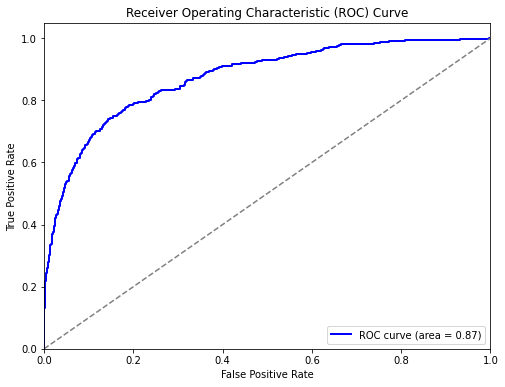

In [108]:
# Calculate ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

## Testing the model with new data

In [109]:
def predict_churn(data, model):
    
    if type(data) == dict:
        df = pd.DataFrame(data)
    else:
        df = data
    
    y_pred = model.predict(df)
    
    if y_pred == 0:
        return 'The customer will potentially stay'
    elif y_pred == 1:
        return 'The customer will potentially churn'


In [113]:
test_data = pd.DataFrame({
    'age': [30],
    'credit_score': [780],
    'tenure':[8],
    'credit_card':[1],
    'products_number':[3],
    'active_member':[1],
    'estimated_salary': [1000000],
    'balance': [200000],
    'gender': ['Male'],
    'country': ['Spain']
})

predict_churn(test_data, best_model_xgb)

'The customer will potentially stay'

 ## Save and use model as pickle file

In [111]:
#Save the trained model as a pickle file in binary mode (wb) so we can use it later to make predictions
with open('customer_churn_xgb_model.pkl', 'wb') as file:
    pickle.dump(best_model_xgb, file)

# Load from file
with open('customer_churn_xgb_model.pkl', 'rb') as file:
    pickle_model = pickle.load(file)